 Parameter     Estimate           SE
 K_max/K_g 0.6920889669 0.0072589894
C50 (mg/L) 0.2122149378 0.0184438842
         H 2.6522900853 0.4248360193

R² = 0.978974280450


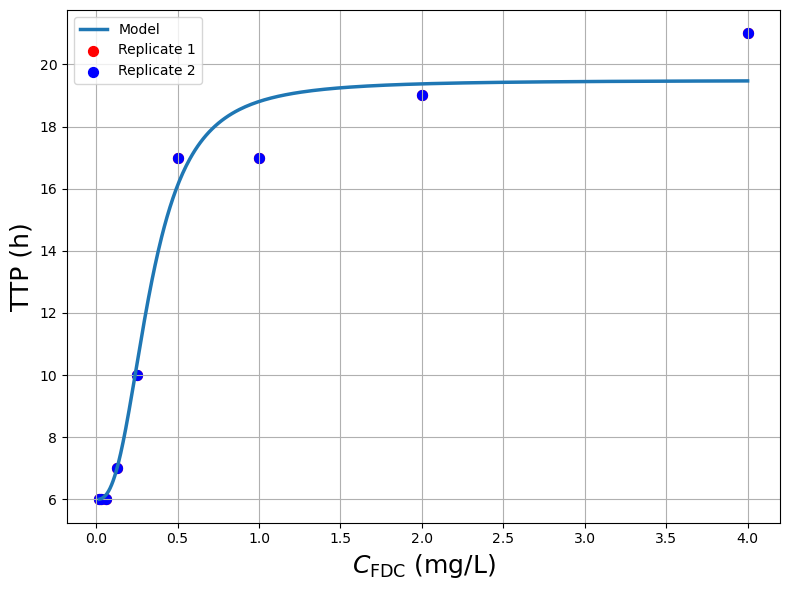

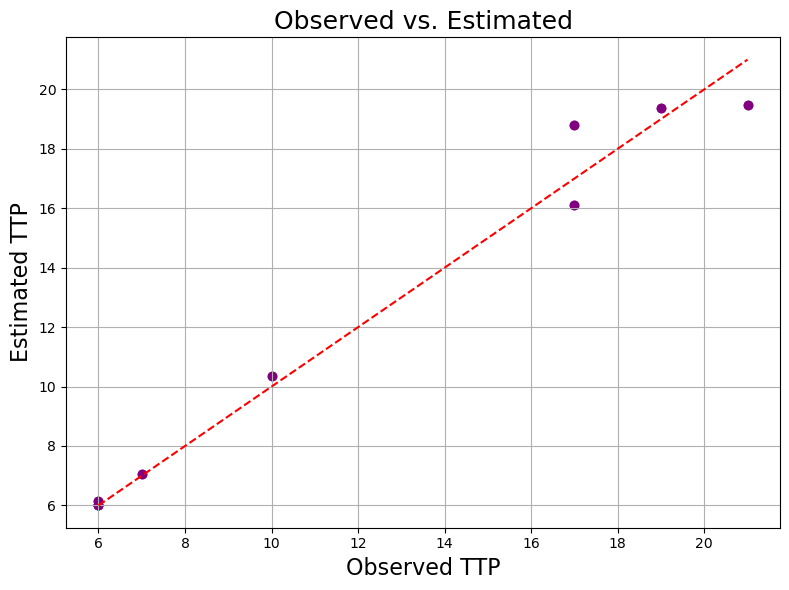

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, Bounds
from scipy.stats import pearsonr

C = np.array([0.02, 0.03, 0.06, 0.13, 0.25, 0.5, 1.0, 2.0, 4.0])
TTP1 = np.array([6, 6, 6, 7, 10, 17, 17, 19, 21])
TTP2 = np.array([6, 6, 6, 7, 10, 17, 17, 19, 21])

C_pooled  = np.concatenate([C, C])
TTP_pooled = np.concatenate([TTP1, TTP2])
T0 = 6.0

def hill_model(C, q, C50, H):
    frac = q * C**H / (C**H + C50**H)
    return T0 / np.clip(1 - frac, np.finfo(float).eps, None)

def objective(params):
    q, C50, H = params
    pred = hill_model(C_pooled, q, C50, H)
    residuals = (pred - TTP_pooled)
    return np.sum(residuals**2)

bounds_de = [(0.01, 10.0), (0.01, 100.0), (0.1, 20.0)]
result_de = differential_evolution(objective, bounds_de, seed=42)
x_global = result_de.x

bounds_slsqp = Bounds([0.01, 0.01, 0.1], [10.0, 100.0, 20.0])
result_local = minimize(objective, x_global, method='trust-constr', bounds=bounds_slsqp)

q_opt, C50_opt, H_opt = result_local.x

def residuals_vector(params):
    q, C50, H = params
    return (hill_model(C_pooled, q, C50, H) - TTP_pooled)

eps = np.sqrt(np.finfo(float).eps)
J = np.zeros((len(C_pooled), 3))
for i in range(3):
    delta = np.zeros(3)
    delta[i] = eps
    J[:, i] = (residuals_vector(result_local.x + delta) - residuals_vector(result_local.x - delta)) / (2 * eps)

n, k = J.shape
sigma2 = np.sum(residuals_vector(result_local.x)**2) / (n - k)
cov = sigma2 * np.linalg.pinv(J.T @ J)
SE = np.sqrt(np.diag(cov))

df = pd.DataFrame({
    'Parameter': ['K_max/K_g', 'C50 (mg/L)', 'H'],
    'Estimate': [q_opt, C50_opt, H_opt],
    'SE': SE,
})
pd.set_option('display.precision', 10)
print(df.to_string(index=False))

TTP_pred = hill_model(C_pooled, q_opt, C50_opt, H_opt)
r2 = pearsonr(TTP_pooled, TTP_pred)[0]**2
print(f"\nR² = {r2:.12f}")

C_fine = np.geomspace(C.min(), C.max(), 400)
T_fine = hill_model(C_fine, q_opt, C50_opt, H_opt)

plt.figure(figsize=(8,6))
plt.plot(C_fine, T_fine, lw=2.5, label="Model")
plt.scatter(C, TTP1, s=50, color="red", label="Replicate 1")
plt.scatter(C, TTP2, s=50, color="blue", label="Replicate 2")
plt.xlabel(r"$C_{\mathrm{FDC}}$ (mg/L)", fontsize=18)
plt.ylabel("TTP (h)", fontsize=18)
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(TTP_pooled, TTP_pred, color="purple")
plt.plot([TTP_pooled.min(), TTP_pooled.max()], [TTP_pooled.min(), TTP_pooled.max()], "r--")
plt.xlabel("Observed TTP", fontsize=16)
plt.ylabel("Estimated TTP", fontsize=16)
plt.title("Observed vs. Estimated", fontsize=18)
plt.grid()
plt.tight_layout()
plt.show()


 Parameter     Estimate           SE
 K_max/K_g 0.6900817500 0.0057951860
C50 (mg/L) 0.2195701179 0.0156783191
         H 3.2540585754 0.5146044627

R² = 0.982031036046


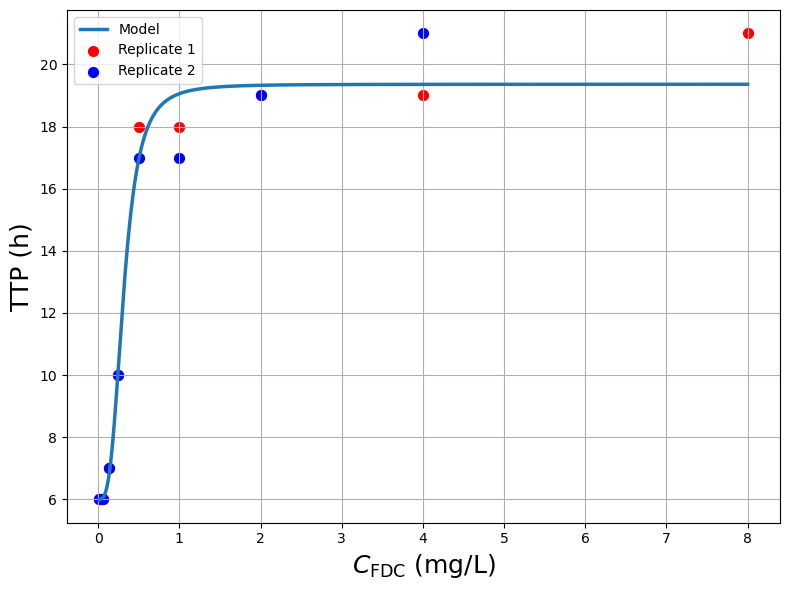

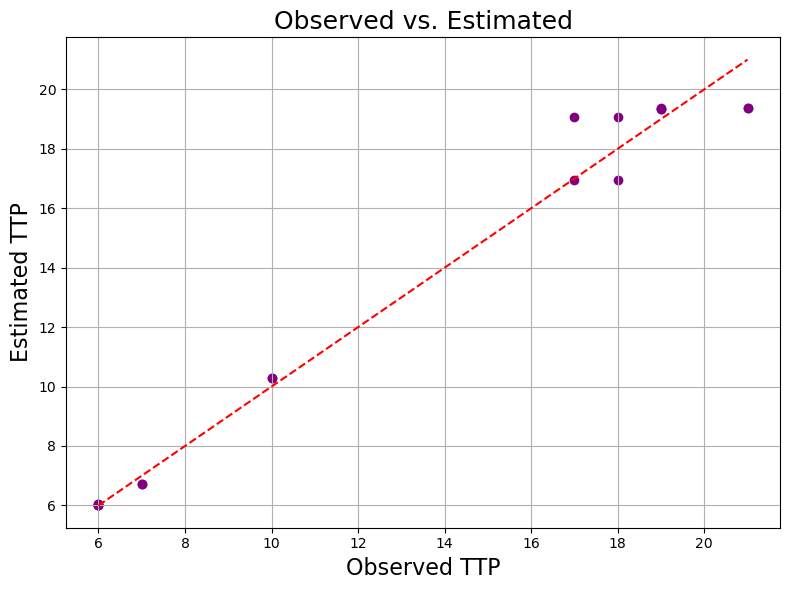

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, Bounds
from scipy.stats import pearsonr

C = np.array([0.016, 0.03, 0.06, 0.13, 0.25, 0.5, 1, 2, 4, 8])
TTP1 = np.array([6, 6, 6, 7, 10, 18, 18, 19, 19, 21])
C_trimmed = C[:9]
TTP2_trimmed = np.array([6, 6, 6, 7, 10, 17, 17, 19, 21])

C_pooled  = np.concatenate([C, C_trimmed])
TTP_pooled = np.concatenate([TTP1, TTP2_trimmed])
T0 = 6.0

def hill_model(C, q, C50, H):
    frac = q * C**H / (C**H + C50**H)
    return T0 / np.clip(1 - frac, np.finfo(float).eps, None)

def objective(params):
    q, C50, H = params
    pred = hill_model(C_pooled, q, C50, H)
    residuals = (pred - TTP_pooled)
    return np.sum(residuals**2)

bounds_de = [(0.01, 10.0), (0.01, 100.0), (0.1, 20.0)]
result_de = differential_evolution(objective, bounds_de, seed=42)
x_global = result_de.x

bounds_tc = Bounds([0.01, 0.01, 0.1], [10.0, 100.0, 20.0])
result_local = minimize(objective, x_global, method='trust-constr', bounds=bounds_tc)

q_opt, C50_opt, H_opt = result_local.x

def residuals_vector(params):
    q, C50, H = params
    return (hill_model(C_pooled, q, C50, H) - TTP_pooled)

eps = np.sqrt(np.finfo(float).eps)
J = np.zeros((len(C_pooled), 3))
for i in range(3):
    delta = np.zeros(3)
    delta[i] = eps
    J[:, i] = (residuals_vector(result_local.x + delta) - residuals_vector(result_local.x - delta)) / (2 * eps)

n, k = J.shape
sigma2 = np.sum(residuals_vector(result_local.x)**2) / (n - k)
cov = sigma2 * np.linalg.pinv(J.T @ J)
SE = np.sqrt(np.diag(cov))

df = pd.DataFrame({
    'Parameter': ['K_max/K_g', 'C50 (mg/L)', 'H'],
    'Estimate': [q_opt, C50_opt, H_opt],
    'SE': SE,
})
pd.set_option('display.precision', 10)
print(df.to_string(index=False))

TTP_pred = hill_model(C_pooled, q_opt, C50_opt, H_opt)
r2 = pearsonr(TTP_pooled, TTP_pred)[0]**2
print(f"\nR² = {r2:.12f}")

C_fine = np.geomspace(C.min(), C.max(), 400)
T_fine = hill_model(C_fine, q_opt, C50_opt, H_opt)

plt.figure(figsize=(8,6))
plt.plot(C_fine, T_fine, lw=2.5, label="Model")
plt.scatter(C, TTP1, s=50, color="red", label="Replicate 1")
plt.scatter(C_trimmed, TTP2_trimmed, s=50, color="blue", label="Replicate 2")
plt.xlabel(r"$C_{\mathrm{FDC}}$ (mg/L)", fontsize=18)
plt.ylabel("TTP (h)", fontsize=18)
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(TTP_pooled, TTP_pred, color="purple")
plt.plot([TTP_pooled.min(), TTP_pooled.max()], [TTP_pooled.min(), TTP_pooled.max()], "r--")
plt.xlabel("Observed TTP", fontsize=16)
plt.ylabel("Estimated TTP", fontsize=16)
plt.title("Observed vs. Estimated", fontsize=18)
plt.grid()
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


 Parameter     Estimate            SE
 K_max/K_g 1.2028381416 17.2013029331
C50 (mg/L) 0.2707324550 78.0309653198
         H 0.1000000304  1.5670237218

R² = 0.020160030640


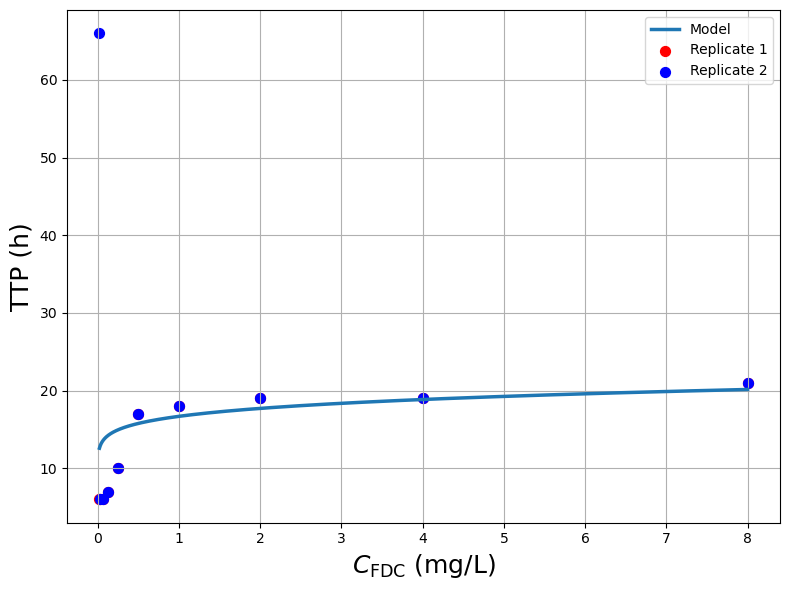

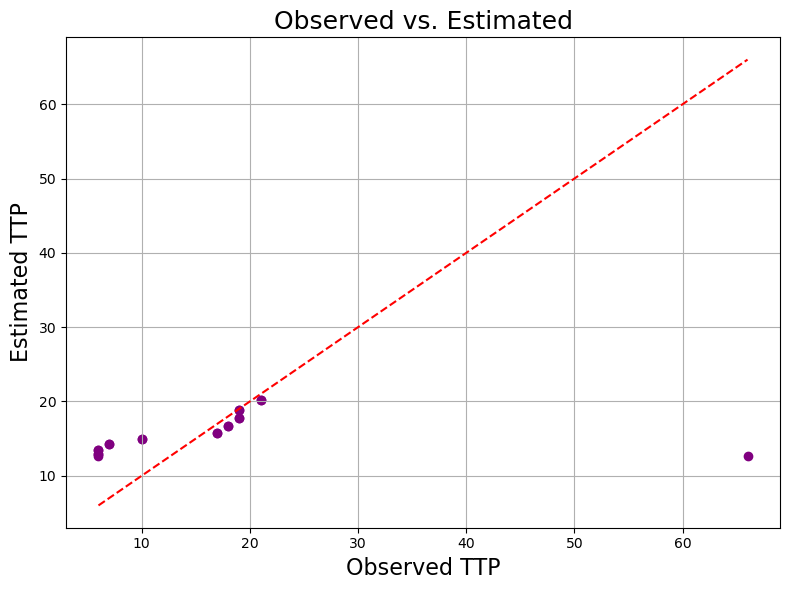

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, Bounds
from scipy.stats import pearsonr

C = np.array([0.02, 0.03, 0.06, 0.13, 0.25, 0.5, 1.0, 2.0, 4.0,8.0])
TTP1 = np.array([6, 6, 6, 7, 10, 17, 18, 19,19, 21])
TTP2 = np.array([66, 6, 6, 7, 10, 17, 18, 19,19, 21])

C_pooled  = np.concatenate([C, C])
TTP_pooled = np.concatenate([TTP1, TTP2])
T0 = 6.0

def hill_model(C, q, C50, H):
    frac = q * C**H / (C**H + C50**H)
    return T0 / np.clip(1 - frac, np.finfo(float).eps, None)

def objective(params):
    q, C50, H = params
    pred = hill_model(C_pooled, q, C50, H)
    residuals = (pred - TTP_pooled)
    return np.sum(residuals**2)

bounds_de = [(0.01, 10.0), (0.01, 100.0), (0.1, 20.0)]
result_de = differential_evolution(objective, bounds_de, seed=42)
x_global = result_de.x

bounds_slsqp = Bounds([0.01, 0.01, 0.1], [10.0, 100.0, 20.0])
result_local = minimize(objective, x_global, method='trust-constr', bounds=bounds_slsqp)

q_opt, C50_opt, H_opt = result_local.x

def residuals_vector(params):
    q, C50, H = params
    return (hill_model(C_pooled, q, C50, H) - TTP_pooled)

eps = np.sqrt(np.finfo(float).eps)
J = np.zeros((len(C_pooled), 3))
for i in range(3):
    delta = np.zeros(3)
    delta[i] = eps
    J[:, i] = (residuals_vector(result_local.x + delta) - residuals_vector(result_local.x - delta)) / (2 * eps)

n, k = J.shape
sigma2 = np.sum(residuals_vector(result_local.x)**2) / (n - k)
cov = sigma2 * np.linalg.pinv(J.T @ J)
SE = np.sqrt(np.diag(cov))

df = pd.DataFrame({
    'Parameter': ['K_max/K_g', 'C50 (mg/L)', 'H'],
    'Estimate': [q_opt, C50_opt, H_opt],
    'SE': SE,
})
pd.set_option('display.precision', 10)
print(df.to_string(index=False))

TTP_pred = hill_model(C_pooled, q_opt, C50_opt, H_opt)
r2 = pearsonr(TTP_pooled, TTP_pred)[0]**2
print(f"\nR² = {r2:.12f}")

C_fine = np.geomspace(C.min(), C.max(), 400)
T_fine = hill_model(C_fine, q_opt, C50_opt, H_opt)

plt.figure(figsize=(8,6))
plt.plot(C_fine, T_fine, lw=2.5, label="Model")
plt.scatter(C, TTP1, s=50, color="red", label="Replicate 1")
plt.scatter(C, TTP2, s=50, color="blue", label="Replicate 2")
plt.xlabel(r"$C_{\mathrm{FDC}}$ (mg/L)", fontsize=18)
plt.ylabel("TTP (h)", fontsize=18)
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(TTP_pooled, TTP_pred, color="purple")
plt.plot([TTP_pooled.min(), TTP_pooled.max()], [TTP_pooled.min(), TTP_pooled.max()], "r--")
plt.xlabel("Observed TTP", fontsize=16)
plt.ylabel("Estimated TTP", fontsize=16)
plt.title("Observed vs. Estimated", fontsize=18)
plt.grid()
plt.tight_layout()
plt.show()
